# Genetischer Algorithmus (GA)

In [2]:
import utils.converter as convert
import utils.presenter as show
import utils.checker as check

In [3]:
import random
from deap import base, creator, tools, algorithms
from collections import defaultdict
import numpy as np

In [4]:
import pandas as pd
# pip install ortools==9.8.3296
from ortools.sat.python import cp_model

In [5]:
import time

In [6]:
main_file_path = "../main_data/{}"

In [7]:
# Datei laden
with open(main_file_path.format("jobshop_instances.json"), "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [8]:
max_time = 60*15

In [9]:
import pandas as pd
import random
from deap import base, creator, tools, algorithms
from collections import defaultdict
import numpy as np

# === 1. Vorbereitung: Operationen extrahieren ===
def preprocess_op_level(df):
    df = df.copy()
    df = df.rename(columns=lambda c: c.strip())
    df = df.rename(columns={"Processing Time": "Processing_Time"})

    print("Spalten im DataFrame:", df.columns.tolist())

    df["Job"] = df["Job"].astype("category")
    job_id_to_name = dict(enumerate(df["Job"].cat.categories))
    df["Job"] = df["Job"].cat.codes
    df["Machine"] = df["Machine"].astype(str)
    df["Operation"] = df["Operation"].astype(int)

    op_data = {}
    for idx, row in df.iterrows():
        key = (row["Job"], row["Operation"])
        val = row["Processing_Time"]
        if pd.isna(val):
            raise ValueError(f"Missing Processing Time at index {idx}")
        op_data[key] = {
            "Machine": row["Machine"],
            "Processing Time": int(val)
        }

    return op_data, job_id_to_name

# === 2. Decoder: Sequenz -> Zeitplan -> Makespan ===
def decode_schedule_op_level(sequence, op_data):
    machine_available = defaultdict(int)
    job_ready = defaultdict(int)
    records = []

    for job, op in sequence:
        key = (job, op)
        op_info = op_data[key]
        m = op_info['Machine']
        p = op_info['Processing Time']

        start = max(job_ready[job], machine_available[m])
        end = start + p

        job_ready[job] = end
        machine_available[m] = end

        records.append({
            'Job': job,
            'Operation': op,
            'Machine': m,
            'Start': start,
            'End': end,
            'Processing Time': p
        })

    df_schedule = pd.DataFrame(records)
    makespan = df_schedule['End'].max()
    return makespan, df_schedule

# === 3. Crossover: reihenfolgetreu pro Job ===
def cx_job_preserving(ind1, ind2):
    size = len(ind1)
    a, b = sorted(random.sample(range(size), 2))
    slice1 = ind1[a:b+1]

    jobs_in_slice = defaultdict(set)
    for job, op in slice1:
        jobs_in_slice[job].add(op)

    def build_child(parent):
        child = []
        for job, op in parent:
            if op not in jobs_in_slice.get(job, set()):
                child.append((job, op))
        child = child[:a] + slice1 + child[a:]
        return creator.Individual(child)

    return build_child(ind2), build_child(ind1)

# === 4. Mutation: nur zwischen Jobs tauschen ===
def mut_preserving_job_order(individual, indpb=0.1):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            j = random.randint(0, size - 1)
            if individual[i][0] != individual[j][0]:  # Nur verschiedene Jobs tauschen
                individual[i], individual[j] = individual[j], individual[i]
    return (individual,)

# === 5. GA Setup ===
def create_ga_solver_op_level(df_instance, ngen=300, pop_size=200, cxpb=0.9, mutpb=0.1, seed=None):
    assert cxpb + mutpb <= 1.0, "❌ cxpb + mutpb muss ≤ 1.0 sein!"

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    op_data, job_id_to_name = preprocess_op_level(df_instance)
    op_list = list(op_data.keys())

    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    def create_individual():
        per_job_ops = defaultdict(list)
        for job, op in op_list:
            per_job_ops[job].append((job, op))
        for job in per_job_ops:
            per_job_ops[job].sort(key=lambda x: x[1])

        num_total_ops = len(op_list)
        job_op_index = {job: 0 for job in per_job_ops}
        individual = []

        while len(individual) < num_total_ops:
            available_jobs = [job for job in per_job_ops if job_op_index[job] < len(per_job_ops[job])]
            job = random.choice(available_jobs)
            op = per_job_ops[job][job_op_index[job]]
            individual.append(op)
            job_op_index[job] += 1

        return creator.Individual(individual)

    def evaluate(ind):
        job_ops = defaultdict(list)
        for job, op in ind:
            job_ops[job].append(op)
        for job, ops in job_ops.items():
            if ops != sorted(ops):
                return (float('inf'),)
        makespan, _ = decode_schedule_op_level(ind, op_data)
        return (makespan,)

    toolbox = base.Toolbox()
    toolbox.register("individual", create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", cx_job_preserving)
    toolbox.register("mutate", mut_preserving_job_order, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaMuPlusLambda(pop, toolbox,
                               mu=pop_size,
                               lambda_=pop_size,
                               cxpb=cxpb,
                               mutpb=mutpb,
                               ngen=ngen,
                               stats=stats,
                               halloffame=hof,
                               verbose=True)

    best_seq = hof[0]
    best_makespan, best_schedule = decode_schedule_op_level(best_seq, op_data)
    best_schedule["Job"] = best_schedule["Job"].map(job_id_to_name)

    return best_schedule, best_makespan


### Scheduling

In [11]:
ngen = 100        # Anzahl Generationen
pop_size = 50    # Populationsgröße
cxpb = 0.8      # Crossover-Wahrscheinlichkeit
mutpb = 0.2      # Mutationswahrscheinlichkeit
seed = 42        # Zufalls-Seed für Reproduzierbarkeit

ngen = 200         # ⬆ Mehr Generationen – mehr Entwicklungsmöglichkeiten
pop_size = 100     # ⬆ Größere Population – mehr Vielfalt
cxpb = 0.6         # ➖ etwas weniger Crossover
mutpb = 0.4        # ⬆ mehr Mutationen = mehr Sprünge
seed = 42          # Wieder gleich lassen, für Vergleichbarkeit


# Aufruf des GA-Solvers
df_plan, best_makespan = create_ga_solver_op_level(
    df_instance,
    ngen=ngen,
    pop_size=pop_size,
    cxpb=cxpb,
    mutpb=mutpb,
    seed=seed
)

# Ausgabe
print(f"Gefundener Makespan: {best_makespan}")

Spalten im DataFrame: ['Job', 'Operation', 'Machine', 'Processing_Time']
gen	nevals	min 	avg    
0  	100   	1426	1822.82
1  	100   	1426	inf    
2  	100   	1426	inf    
3  	100   	1426	inf    
4  	100   	1426	inf    
5  	100   	1426	inf    
6  	100   	1426	inf    
7  	100   	1426	inf    
8  	100   	1410	inf    
9  	100   	1410	inf    
10 	100   	1410	inf    
11 	100   	1410	inf    
12 	100   	1360	inf    
13 	100   	1360	inf    
14 	100   	1290	inf    
15 	100   	1290	inf    
16 	100   	1290	inf    
17 	100   	1290	inf    
18 	100   	1290	inf    
19 	100   	1290	inf    
20 	100   	1290	inf    
21 	100   	1290	1292.4 
22 	100   	1290	inf    
23 	100   	1290	inf    
24 	100   	1290	inf    
25 	100   	1290	inf    
26 	100   	1290	inf    
27 	100   	1290	inf    
28 	100   	1290	1290   
29 	100   	1290	1290   
30 	100   	1290	1290   
31 	100   	1290	1290   
32 	100   	1290	inf    
33 	100   	1290	inf    
34 	100   	1290	1290   
35 	100   	1290	1290   
36 	100   	1290	inf    
37 	100   	1290

In [12]:
df_plan.sort_values(by=["Job", "Operation"]).head(20)

,Job,Operation,Machine,Start,End,Processing Time
1,job 0,0,M0,43,72,29
42,job 0,1,M1,549,627,78
44,job 0,2,M2,627,636,9
46,job 0,3,M3,636,672,36
53,job 0,4,M4,672,721,49
57,job 0,5,M5,768,779,11
62,job 0,6,M6,779,841,62
71,job 0,7,M7,841,897,56
77,job 0,8,M8,1063,1107,44
95,job 0,9,M9,1219,1240,21


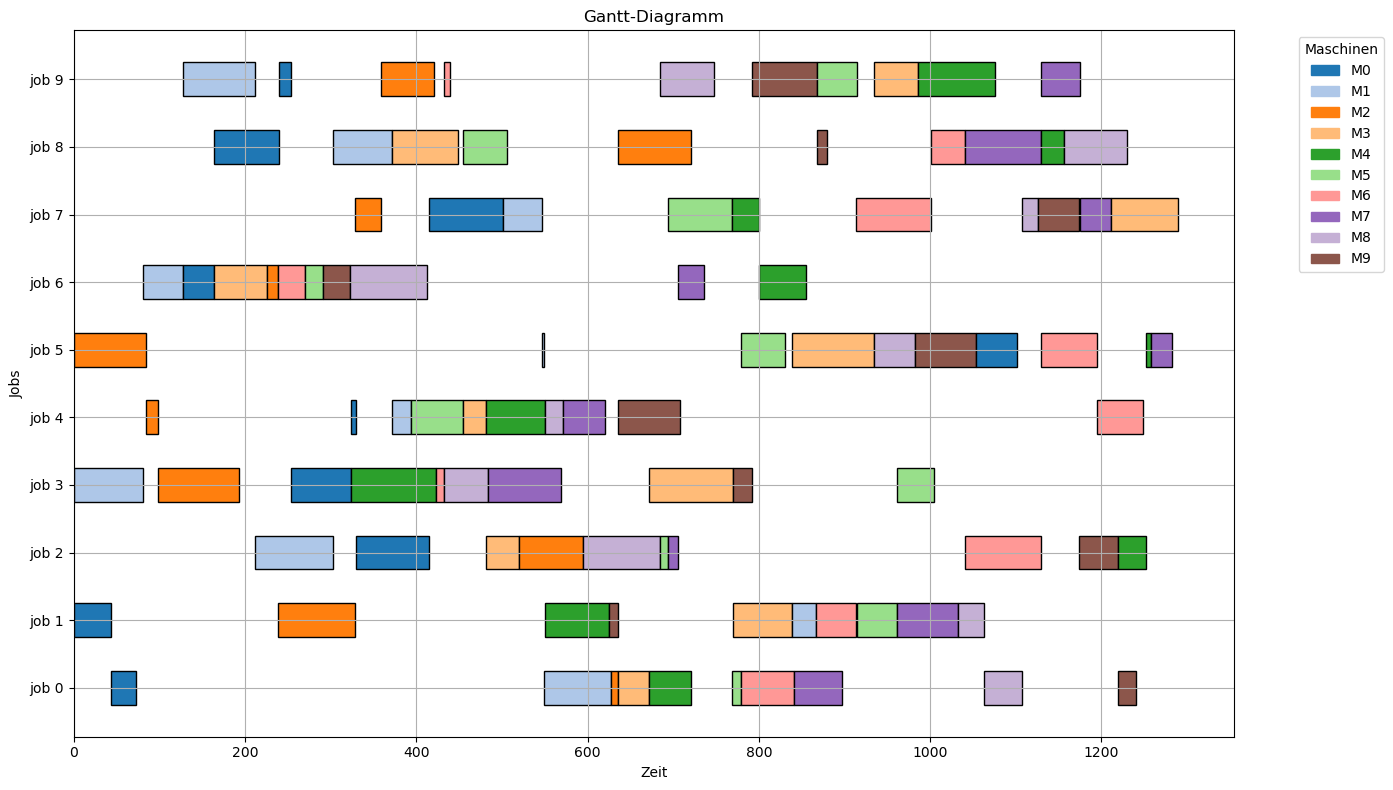

In [13]:
show.plot_gantt_jobs(df_plan)

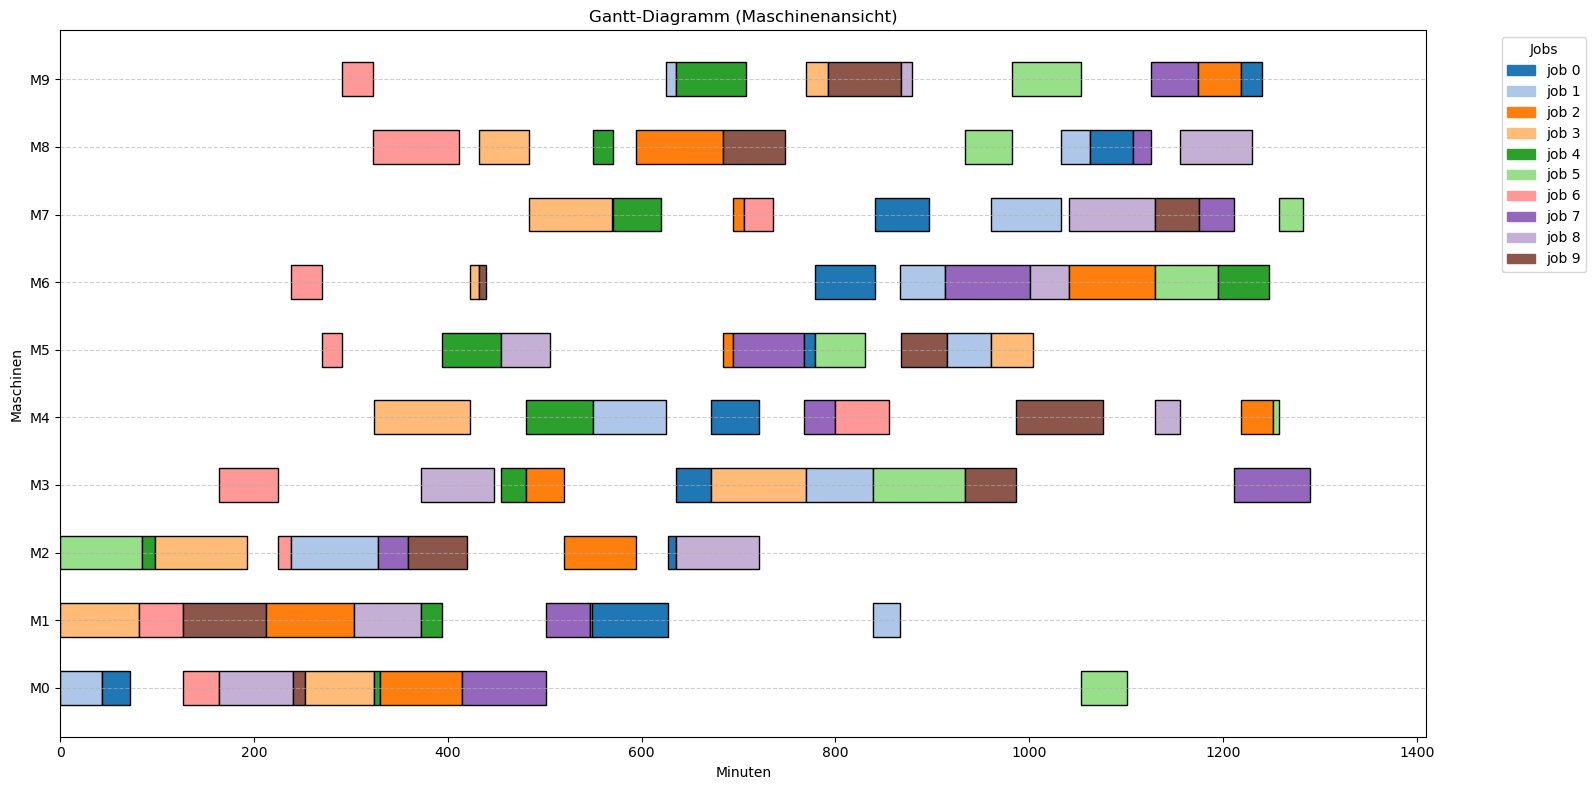

In [14]:
show.plot_gantt_machines(df_plan)

In [15]:
df_plan.End.max()

1290

In [16]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.


True